In [1]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
import pandas as pd
import json
from PIL import Image
import ipyplot
import random
from scipy.special import softmax
from scipy import stats
from scipy.stats import bernoulli
import random, math
import statsmodels.api as sm
import choix
import networkx as nx
from pathlib import Path
from shutil import copy2
from prettytable import PrettyTable
from PIL import Image
import requests
from io import BytesIO
from scipy.stats import norm
from sklearn.neighbors import KernelDensity


pd.options.display.max_rows = 100
random_state = 42

In [2]:
df = pd.read_csv('data/crowdsourced_annotation_output/Batch_4555956_batch_results.csv')

In [3]:
cat = df['Input.category'].unique()[0]

In [4]:
# four outcomes: tasty, healthy, caloric, homemade

In [5]:
cols_relevant = ['WorkerId','Input.image_1', 'Input.image_2', 'Answer.caloric',
                 'Answer.healthy', 'Answer.homemade', 'Answer.tasty' ,
       'Answer.tag1_1', 'Answer.tag1_2', 'Answer.tag1_3', 'Answer.tag2_1',
       'Answer.tag2_2', 'Answer.tag2_3', 'Input.image_1_url', 'Input.image_2_url']

In [6]:
df = df[cols_relevant]

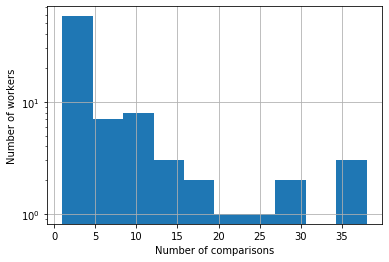

In [7]:
df['WorkerId'].value_counts().hist()
plt.ylabel('Number of workers')
plt.xlabel('Number of comparisons')
plt.yscale('log')

In [8]:
outcome = 'Answer.tasty'
#outcome = 'Answer.healthy'
#outcome = 'Answer.caloric'
#outcome = 'Answer.homemade'

## 1. Analyze wins and looses overall

In [9]:
wins_twitter = len(df.loc[(df['Input.image_1']=='T') & \
           (df[outcome]==1)]) + \
len(df.loc[(df['Input.image_2']=='T') & \
           (df[outcome]==2)])
print(wins_twitter)
print(wins_twitter/500)

338
0.676


In [10]:
wins_real = len(df.loc[(df['Input.image_1']=='R') & \
           (df[outcome]==1)]) + \
len(df.loc[(df['Input.image_2']=='R') & \
           (df[outcome]==2)])
print(wins_real)
print(wins_real/500)

162
0.324


In [11]:
stats.binom_test(wins_twitter, n=wins_real+wins_twitter,
                 p=0.5, alternative='two-sided')

2.604487239019693e-15

In [12]:
winners = []
for cnt,row in df.iterrows():
    if (row['Input.image_1']=='T' and row[outcome]==1) or \
        (row['Input.image_2']=='T' and row[outcome]==2):
        winners.append('Twitter')
    else:
        winners.append('Real')


In [13]:
df['winner'] = winners

## 2. Estimate rank

In [14]:
images_competing = pd.Series(sorted(np.unique(list(df['Input.image_1_url'].unique()) + list(df['Input.image_2_url'].unique()))))

In [15]:
len(images_competing)

100

In [16]:
data = []
for cnt,row in df.iterrows():
    id_1 = (images_competing[images_competing == \
                            row['Input.image_1_url']].index[0])
    id_2 = (images_competing[images_competing == \
                            row['Input.image_2_url']].index[0])
    
    if row[outcome] == 1:
        data.append((id_1, id_2))
    else:
        data.append((id_2, id_1))
    

In [17]:
df_comparisons = pd.DataFrame()
df_comparisons['image'] = images_competing

In [18]:
estimations = choix.ilsr_pairwise(len(images_competing), data, alpha=0.01)

In [19]:
df_comparisons['estimated'] = estimations

In [20]:
df_comparisons['rank'] = df_comparisons['estimated'].rank(method = 'average',
     ascending = False)

In [21]:
#median rank of real
df_comparisons.iloc[:50]['rank'].median()

68.5

In [22]:
#median rank of twitter
df_comparisons.iloc[50:]['rank'].median()

28.0

In [23]:
#median rank overall
df_comparisons['rank'].median()

50.5

In [24]:
x = np.array(range(1,100,1))
ys= []

for iteration in range(100):
    quality_real_estimated = df_comparisons.iloc[:50]['estimated'].sample(50, replace = True).values
    quality_twitter_estimated = df_comparisons.iloc[50:]['estimated'].sample(50, replace = True).values
    
    y_tmp= []
    for percentile in x:
        y_tmp.append(stats.percentileofscore(quality_real_estimated, 
                                      np.percentile(quality_twitter_estimated,percentile), 
                                      kind='rank'))
    ys.append(y_tmp)
    

In [25]:
lower_error = []
upper_error = []
for p in x:
    lower_error.append(np.percentile(np.percentile(np.array(ys),p, axis = 1), 2.5))
    upper_error.append(np.percentile(np.percentile(np.array(ys),p, axis = 1), 97.5))

In [26]:
quality_real_estimated = df_comparisons.iloc[:50]['estimated'].values
quality_twitter_estimated = df_comparisons.iloc[50:]['estimated'].values

In [27]:
y_estimated = []
for percentile in x:
    y_estimated.append(stats.percentileofscore(quality_real_estimated, 
                                  np.percentile(quality_twitter_estimated,percentile), 
                                  kind='rank'))

In [28]:
x = np.array(range(1,100,1))
ys= []

for iteration in range(100):

    estimations = choix.ilsr_pairwise(len(images_competing), random.choices(data,k = 500), alpha=0.01)

    df_comparisons['estimated'] = estimations
    
    quality_real_estimated = df_comparisons.iloc[:50]['estimated'].values
    quality_twitter_estimated = df_comparisons.iloc[50:]['estimated'].values
    
    y_tmp= []
    for percentile in x:
        y_tmp.append(stats.percentileofscore(quality_real_estimated, 
                                      np.percentile(quality_twitter_estimated,percentile), 
                                      kind='rank'))
    ys.append(y_tmp)

In [29]:
lower_error = []
upper_error = []
bootstrapped_estimate = [] 
for p in x:
    lower_error.append(np.percentile(np.percentile(np.array(ys),p, axis = 1), 2.5))
    upper_error.append(np.percentile(np.percentile(np.array(ys),p, axis = 1), 97.5))
    bootstrapped_estimate.append(np.percentile(np.percentile(np.array(ys),p, axis = 1),50))

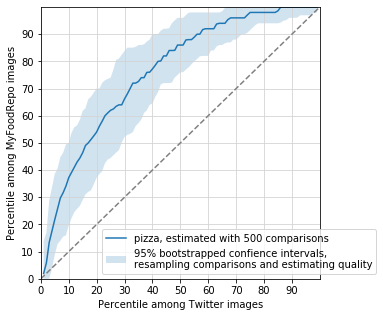

In [30]:
fig, axs = plt.subplots(1,1,figsize= (5,5))
plt.plot(x,bootstrapped_estimate,label = 'pizza, estimated with 500 comparisons')

plt.fill_between(x,lower_error, upper_error, alpha = 0.2, \
                 label = "95% bootstrapped confience intervals,\nresampling comparisons and estimating quality")


plt.plot([0,100],[0,100],linestyle = '--', color = 'gray')
plt.xlim([0,100])
plt.ylim([0,100])

plt.ylabel('Percentile among MyFoodRepo images')
plt.xlabel('Percentile among Twitter images')
plt.xticks(range(0,100,10))
plt.yticks(range(0,100,10))

plt.grid(color = 'lightgray')
plt.legend(bbox_to_anchor=[0.2, 0.2])



(array([ 1.,  1.,  0.,  2.,  1.,  5.,  5., 14.,  9., 12.]),
 array([-2.68459957, -2.26616534, -1.84773112, -1.4292969 , -1.01086268,
        -0.59242846, -0.17399424,  0.24443998,  0.6628742 ,  1.08130842,
         1.49974265]),
 <a list of 10 Patch objects>)

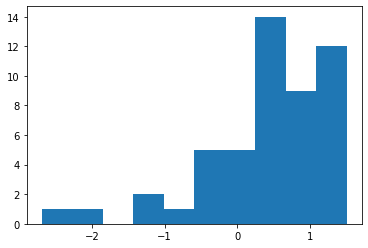

In [31]:
plt.hist(df_comparisons.iloc[50:]['estimated'].values)

In [32]:
bootstrapped_estimate[17]

51.28

In [33]:
bootstrapped_estimate[49]

86.0

([], <a list of 0 Text yticklabel objects>)

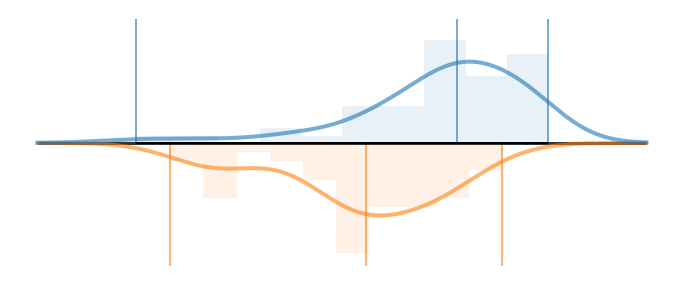

In [34]:
n1,bins1,bars1 = plt.hist(df_comparisons.iloc[:50]['estimated'].values, 
                       range = [df_comparisons['estimated'][:50].values.min(), 
                                 df_comparisons['estimated'][:50].values.max()], density = True,  bins = 10)

n2,bins2,bars2 = plt.hist(df_comparisons.iloc[50:]['estimated'].values, 
                       range = [df_comparisons['estimated'][50:].values.min(), 
                                 df_comparisons['estimated'][50:].values.max()], density = True, bins = 10)

plt.close()

fig,ax = plt.subplots(1,1,figsize= (12,5))

plt.bar(bins1[:-1]+(bins1[1] - bins1[0])/2, -n1,  width = (bins1[1] - bins1[0]), color = 'tab:orange',alpha = 0.1)




kde = KernelDensity(kernel='gaussian', 
                    bandwidth=0.4).fit(df_comparisons.iloc[:50]['estimated'].values.reshape(-1, 1))
X_plot = np.linspace(df_comparisons['estimated'].values.min()-1, 
                    df_comparisons['estimated'].values.max()+1,
                     1000)[:, np.newaxis]
log_dens = kde.score_samples(X_plot)
plt.plot(X_plot[:, 0], -np.exp(log_dens), color = 'tab:orange',alpha = 0.6, linewidth = 4)

plt.hlines(0,df_comparisons['estimated'].values.min(), 
                                 df_comparisons['estimated'].values.max(), linewidth = 2)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)


plt.xticks([])
plt.yticks([])



plt.bar(bins2[:-1]+(bins2[1] - bins2[0])/2, n2, width = (bins2[1] - bins2[0]), color = 'tab:blue',alpha = 0.1)


plt.vlines(np.percentile(df_comparisons.iloc[:50]['estimated'].values, 0),-0.8,0, color = 'tab:orange',alpha = 0.6, linewidth = 2)

plt.vlines(np.percentile(df_comparisons.iloc[:50]['estimated'].values, 50),-0.8,0, color = 'tab:orange',alpha = 0.6, linewidth = 2)

plt.vlines(np.percentile(df_comparisons.iloc[:50]['estimated'].values, 100),-0.8,0, color = 'tab:orange',alpha = 0.6, linewidth = 2)



plt.vlines(np.percentile(df_comparisons.iloc[50:]['estimated'].values, 0),0,0.8, color = 'tab:blue',alpha = 0.6, linewidth = 2)

plt.vlines(np.percentile(df_comparisons.iloc[50:]['estimated'].values, 50),0,0.8, color = 'tab:blue',alpha = 0.6, linewidth = 2)

plt.vlines(np.percentile(df_comparisons.iloc[50:]['estimated'].values, 100),0,0.8, color = 'tab:blue',alpha = 0.6, linewidth = 2)


kde = KernelDensity(kernel='gaussian', 
                    bandwidth=0.4).fit(df_comparisons.iloc[50:]['estimated'].values.reshape(-1, 1))
X_plot = np.linspace(df_comparisons['estimated'].values.min()-1, 
                    df_comparisons['estimated'].values.max()+1,
                     1000)[:, np.newaxis]
log_dens = kde.score_samples(X_plot)
plt.plot(X_plot[:, 0], np.exp(log_dens), color = 'tab:blue',alpha = 0.6, linewidth = 4)

plt.hlines(0,df_comparisons['estimated'].values.min()-1, 
                                 df_comparisons['estimated'].values.max()+1, linewidth = 3, alpha = 0.8)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)


plt.xticks([])
plt.yticks([])

##  Best 5

In [35]:
image_list = []
show_labels = []
for i in df_comparisons.sort_values(by = 'rank')['image'].values[:30]:
        if cat == 'pizza':
            img = Image.open("data/images_competing/" +cat+"/"+i.split('/')[-1][-10:])
        else:
            img = Image.open("data/images_competing/" +cat+"/"+i.split('/')[-1])
        image_list.append(img)
        show_labels.append(i.split('/')[-1][-10:])

    


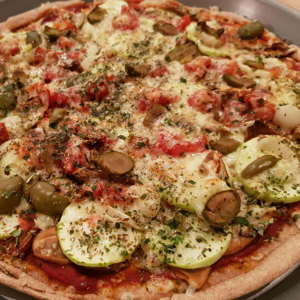
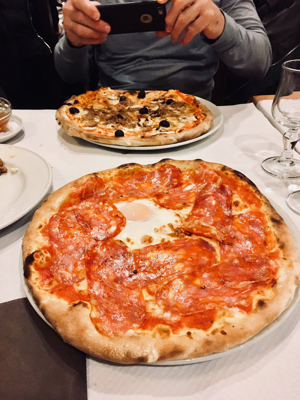
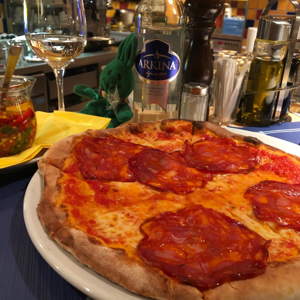
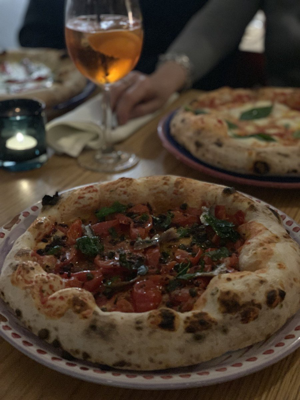
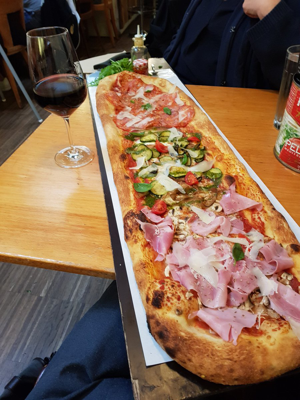


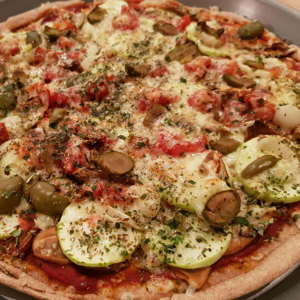
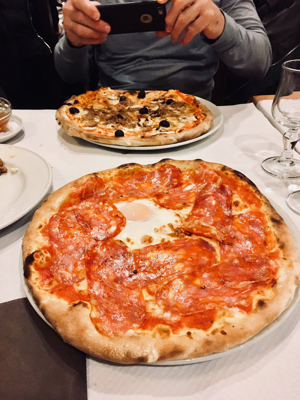
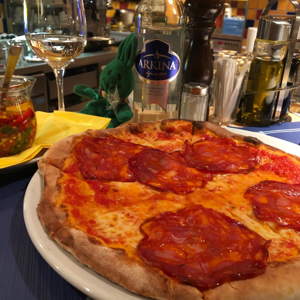
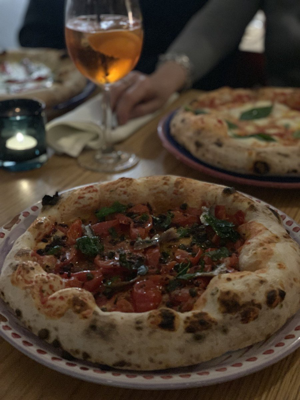
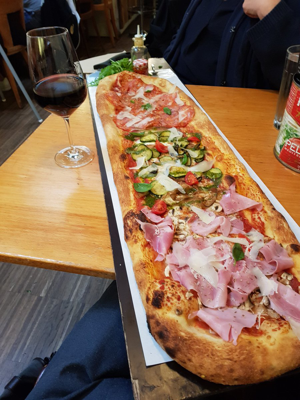

In [36]:
ipyplot.plot_images(image_list, max_images = 5, labels = show_labels, img_width=300)

## 5. Bottom 5

In [37]:
image_list = []
show_labels = []
for i in df_comparisons.sort_values(by = 'rank')['image'].values[-5:]:
        if cat == 'pizza':
            img = Image.open("data/images_competing/" +cat+"/"+i.split('/')[-1][-10:])
        else:
            img = Image.open("data/images_competing/" +cat+"/"+i.split('/')[-1])
        image_list.append(img)
        show_labels.append(i.split('/')[-1][-10:])



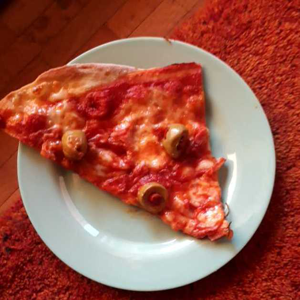
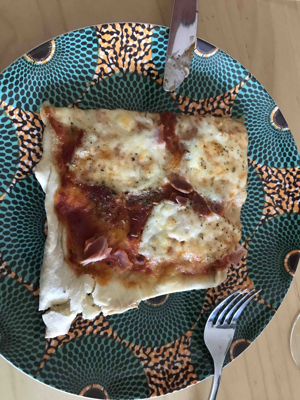
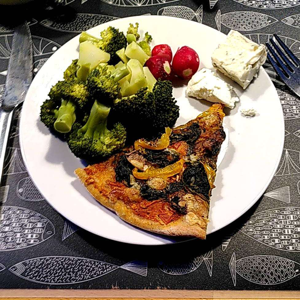
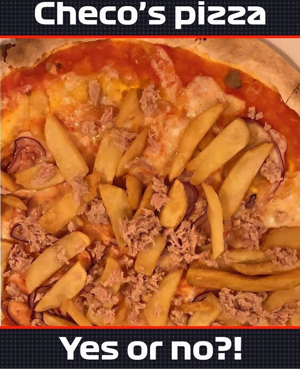
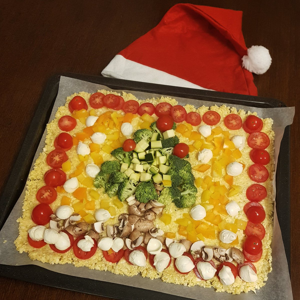


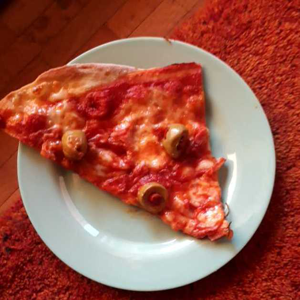
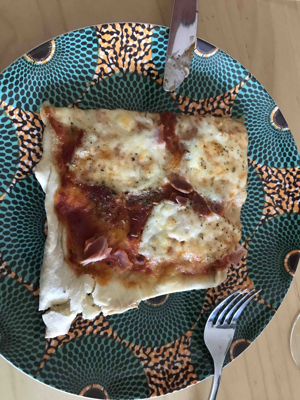
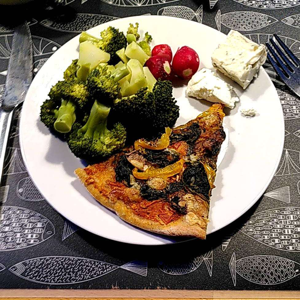
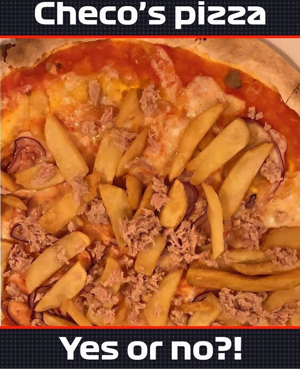
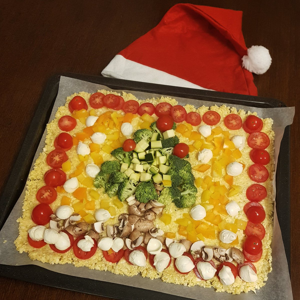

In [38]:
ipyplot.plot_images(image_list, max_images = 5, labels = show_labels, img_width=300)

In [39]:
show_labels

['035059.jpg', '038596.jpg', '102823.jpg', 'AAGhJY.jpg', 'AAo5gs.jpg']

In [40]:
image_list = []
show_labels = []
i = df_comparisons.loc[50:].sort_values(by = 'rank').iloc[25]['image']
if cat == 'pizza':
    img = Image.open("data/images_competing/" +cat+"/"+i.split('/')[-1][-10:])
else:
    img = Image.open("data/images_competing/" +cat+"/"+i.split('/')[-1])
image_list.append(img)
show_labels.append(i.split('/')[-1][-10:])



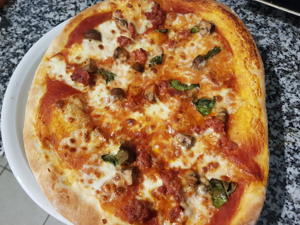


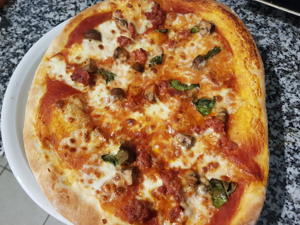

In [41]:
ipyplot.plot_images(image_list, max_images = 100, labels = show_labels, img_width=300)

In [42]:
image_list = []
show_labels = []
i = df_comparisons.loc[:50].sort_values(by = 'rank').iloc[25]['image']
if cat == 'pizza':
    img = Image.open("data/images_competing/" +cat+"/"+i.split('/')[-1][-10:])
else:
    img = Image.open("data/images_competing/" +cat+"/"+i.split('/')[-1])
image_list.append(img)
show_labels.append(i.split('/')[-1][-10:])



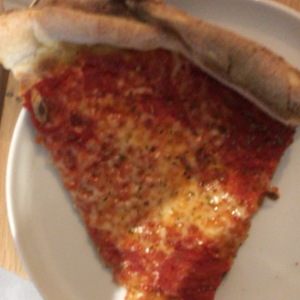


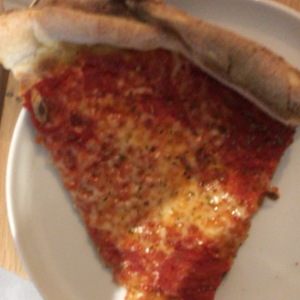

In [43]:
ipyplot.plot_images(image_list, max_images = 100, labels = show_labels, img_width=300)